In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import torch.nn.functional as F

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(root=r'/kaggle/input/pest-data/Testing_Data', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Calculate IoU for each class
    unique_classes = np.unique(y_true)
    iou_per_class = {}
    
    for cls in unique_classes:
        intersection = np.logical_and(y_pred == cls, y_true == cls).sum()
        union = np.logical_or(y_pred == cls, y_true == cls).sum()
        iou = intersection / union if union > 0 else 0
        iou_per_class[cls] = iou

    # Calculate mean IoU
    mean_iou = np.mean(list(iou_per_class.values()))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(unique_classes)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    y_true_binary = np.eye(n_classes)[y_true]
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    cm = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm

# Function to plot ROC curve for multiclass
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure()
    for i in range(len(fpr) - 1):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (area = {roc_auc["micro"]:.2f})', color='darkorange', linestyle='--')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(f'roc_curve_{model_name}.png')  # Save ROC curve
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'confusion_matrix_{model_name}.png')  # Save confusion matrix
    plt.show()

# Function to evaluate model performance
def evaluate_model(model_path, test_loader, model_name, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = torch.load(model_path, map_location=device)
    model.eval()
    model = model.to(device)

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = nn.Softmax(dim=1)(outputs)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy, precision, recall, f1, mean_iou, iou_per_class, fpr, tpr, roc_auc, cm = calculate_metrics(
        all_labels, all_preds, all_probs
    )
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, F1 Score: {f1:.4f}, Mean IoU: {mean_iou:.4f}")
    
    # Print IoU for each class
    for cls, iou in iou_per_class.items():
        print(f"IoU for Class {cls}: {iou:.4f}")
    
    plot_roc_curve(fpr, tpr, roc_auc, model_name)
    plot_confusion_matrix(cm, class_names, model_name)

# Example usage
# evaluate_model('path_to_your_model.pth', test_loader, 'Model Name', class_names)

In [8]:
# class_names = test_dataset.classes
# evaluate_model("/kaggle/input/densenet201pure/pytorch/default/1/bestDensenet201.pth", test_loader, "DenseNet201", class_names)

# Define the KANLinear class
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=10, spline_order=4, 
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0, 
                 enable_standalone_scale_spline=True, grid_eps=0.01, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = nn.SiLU()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) *
                                          self.curve2coeff(self.grid.T[self.spline_order: -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k + 1)]) / (grid[:, k:-1] - grid[:, :-(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1:] - x) / (grid[:, k + 1:] - grid[:, 1:(-k)]) * bases[:, :, 1:])

        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)  
        B = y.transpose(0, 1)  
        solution = torch.linalg.lstsq(A, B).solution  
        result = solution.permute(2, 0, 1)

        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        x = x.to(self.grid.device)  
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1),
                                 self.scaled_spline_weight.view(self.out_features, -1))
        output = base_output + spline_output
    
        output = output.view(*original_shape[:-1], self.out_features)
        return output

# Modified Densenet201 model with KANLinear layer
class DensenetKANModel(nn.Module):
    def __init__(self, num_classes=22):
        super(DensenetKANModel, self).__init__()
        self.densenet = models.densenet201(pretrained=True)

        # Replace the Densenet classifier with a custom KANLinear layer
        self.kan_layer = KANLinear(in_features=self.densenet.classifier.in_features, 
                                   out_features=num_classes)
        self.densenet.classifier = nn.Identity()  # Remove the default linear layer

    def forward(self, x):
        x = self.densenet(x)  # Pass through Densenet
        x = self.kan_layer(x)  # Pass through KANLinear layer
        return x
    
    

True


/tmp/ipykernel_341/3629785770.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


DenseNet201+KAN - Accuracy: 0.9485, Precision: 0.9499, Recall: 0.9485, F1 Score: 0.9483, Mean IoU: 0.9068
IoU for Class 0: 0.8612
IoU for Class 1: 0.8993
IoU for Class 2: 0.8762
IoU for Class 3: 0.9340
IoU for Class 4: 0.9782
IoU for Class 5: 0.8989
IoU for Class 6: 0.9859
IoU for Class 7: 0.9170
IoU for Class 8: 0.9488
IoU for Class 9: 0.8266
IoU for Class 10: 0.9667
IoU for Class 11: 0.9772
IoU for Class 12: 0.7862
IoU for Class 13: 0.8945
IoU for Class 14: 0.8905
IoU for Class 15: 0.8809
IoU for Class 16: 0.7607
IoU for Class 17: 0.9378
IoU for Class 18: 0.9767
IoU for Class 19: 0.9267
IoU for Class 20: 0.9297
IoU for Class 21: 0.8953


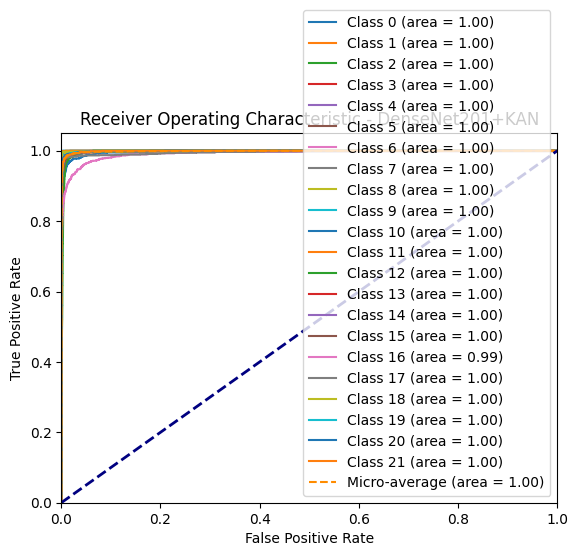

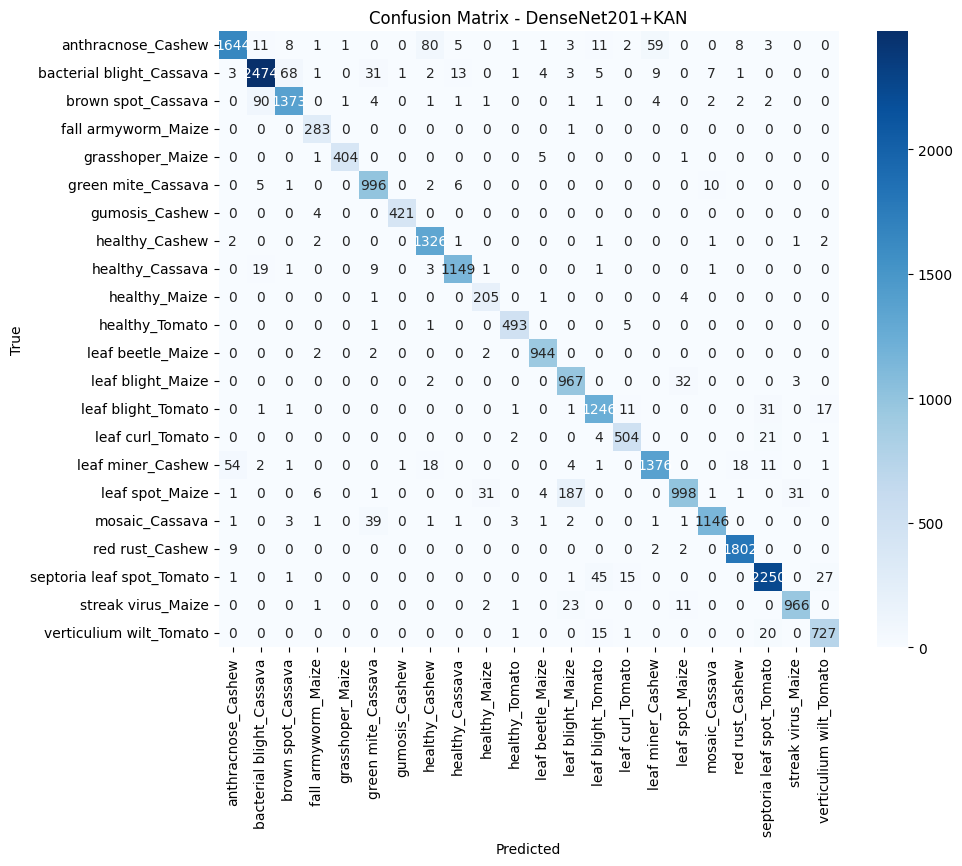

/tmp/ipykernel_341/3629785770.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [9]:
print(torch.cuda.is_available())


models = {
    'DenseNet201+KAN':'/kaggle/input/models/other/default/1/best_model (1).pth',
    'CustomCNN+KAN':'/kaggle/input/models/other/default/1/kan_resnet18_ep41.pth',
    'DenseNet121': '/kaggle/input/models/other/default/1/model_den121.h5',
    'MobileNetV2': '/kaggle/input/models/other/default/1/model_mobv2.h5'
}
class_names = test_dataset.classes

# Evaluate each model
for model_name, model_path in models.items():
    evaluate_model(model_path, test_loader, model_name, class_names)